In [1]:
import os
import numpy as np
import moviepy.editor as mp
from pydub import AudioSegment
import librosa
from sklearn.decomposition import FastICA
from scipy.io.wavfile import write

# Step 1: Extract audio from MP4 video and save it as MP3
def extract_audio_from_video(mp4_file, mp3_file):
    video = mp.VideoFileClip(mp4_file)
    video.audio.write_audiofile(mp3_file)

# Step 2: Convert MP3 to WAV
def convert_mp3_to_wav(mp3_file, wav_file):
    sound = AudioSegment.from_mp3(mp3_file)
    sound.export(wav_file, format="wav")

# Step 3: Load WAV audio and perform ICA on 3 components
def apply_ica_to_audio(wav_file, n_components=3):
    # Load the audio file with librosa
    y, sr = librosa.load(wav_file, sr=None, mono=False)
    
    # Reshape if audio has multiple channels (stereo to 2D)
    if len(y.shape) == 1:
        y = y[np.newaxis, :]
    
    # Transpose to make sure the shape is correct for ICA (samples, channels)
    y = y.T
    
    # Apply ICA to decompose into components
    ica = FastICA(n_components=n_components)
    S_ = ica.fit_transform(y)  # Reconstruct signals
    
    # Normalize the separated signals
    S_ = S_ / np.max(np.abs(S_), axis=0)
    
    # Save the separated components as individual WAV files
    for i, component in enumerate(S_.T):
        output_file = f"separated_component_{i+1}.wav"
        write(output_file, sr, component.astype(np.float32))
        print(f"Saved: {output_file}")

# Example usage
mp4_file = "music/20240413_225917.mp4"  # Input MP4 video file
mp3_file = "music/extracted_audio.mp3"  # Extracted MP3 audio file
wav_file = "music/audio.wav"  # WAV file for processing

# Step 1: Extract audio from MP4 and save as MP3
extract_audio_from_video(mp4_file, mp3_file)

# Step 2: Convert MP3 to WAV
convert_mp3_to_wav(mp3_file, wav_file)

# Step 3: Apply ICA to the extracted audio and save 3 separated components
apply_ica_to_audio(wav_file, n_components=2)


MoviePy - Writing audio in extracted_audio.mp3


MoviePy - Done.
Saved: separated_component_1.wav
Saved: separated_component_2.wav


In [2]:
import os
import numpy as np
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
import librosa
from sklearn.decomposition import FastICA
from scipy.io.wavfile import write
from scipy import signal

# Step 1: Extract audio from MP4 video and save it as MP3
def extract_audio_from_video(mp4_file, mp3_file):
    video = VideoFileClip(mp4_file)
    video.audio.write_audiofile(mp3_file)

# Step 2: Convert MP3 to WAV
def convert_mp3_to_wav(mp3_file, wav_file):
    sound = AudioSegment.from_mp3(mp3_file)
    sound.export(wav_file, format="wav")

# Step 3: High-pass filter the audio signal to remove low-frequency noise
def highpass_filter(audio, sr, cutoff=100):
    sos = signal.butter(10, cutoff, 'hp', fs=sr, output='sos')
    filtered_audio = signal.sosfilt(sos, audio)
    return filtered_audio

# Step 4: Load WAV audio, preprocess, and perform ICA on 3 components
def apply_ica_to_audio(wav_file, n_components=3, tol=0.00001, max_iter=2000):
    # Load the audio file with librosa
    y, sr = librosa.load(wav_file, sr=None, mono=False)
    
    # Reshape if audio has multiple channels (stereo to 2D)
    if len(y.shape) == 1:
        y = y[np.newaxis, :]  # Make mono audio 2D to keep compatibility

    # Apply a high-pass filter to remove low-frequency noise (preprocessing)
    y_filtered = highpass_filter(y, sr)
    
    # Normalize/Standardize the audio signal
    y_filtered = y_filtered / np.max(np.abs(y_filtered))

    # Transpose to ensure the shape is correct for ICA (samples, channels)
    y_filtered = y_filtered.T
    
    # Apply ICA to decompose into components
    ica = FastICA(n_components=n_components, tol=tol, max_iter=max_iter, fun='logcosh')
    S_ = ica.fit_transform(y_filtered)  # Reconstruct signals
    
    # Normalize the separated signals
    S_ = S_ / np.max(np.abs(S_), axis=0)
    
    # Save the separated components as individual WAV files
    for i, component in enumerate(S_.T):
        output_file = f"improved_separated_component_{i+1}.wav"
        write(output_file, sr, component.astype(np.float32))
        print(f"Saved: {output_file}")

# Example usage
mp4_file = "music/20240413_225917.mp4"  # Input MP4 video file
mp3_file = "music/extracted_audio.mp3"  # Extracted MP3 audio file
wav_file = "music/audio.wav"  # WAV file for processing

# Step 1: Extract audio from MP4 and save as MP3
extract_audio_from_video(mp4_file, mp3_file)

# Step 2: Convert MP3 to WAV
convert_mp3_to_wav(mp3_file, wav_file)

# Step 3: Apply ICA to the extracted audio and save 3 separated components
apply_ica_to_audio(wav_file, n_components=3)


MoviePy - Writing audio in extracted_audio.mp3


MoviePy - Done.
Saved: improved_separated_component_1.wav
Saved: improved_separated_component_2.wav


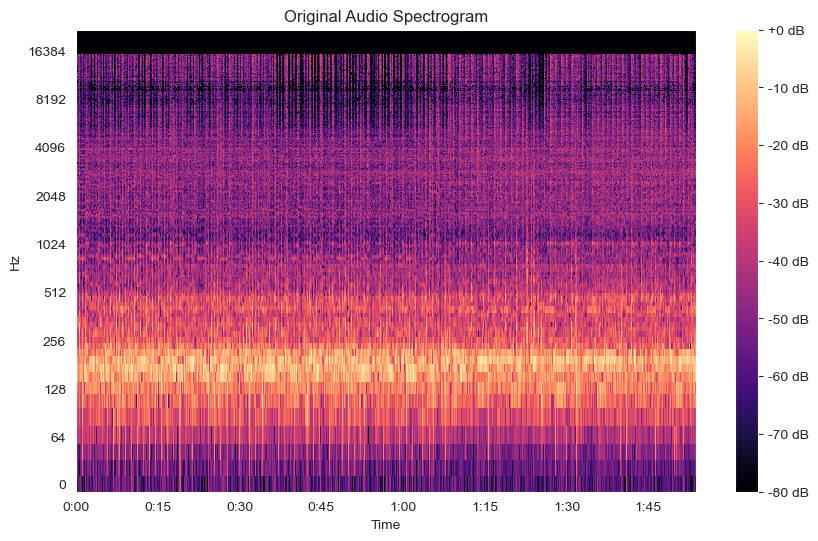

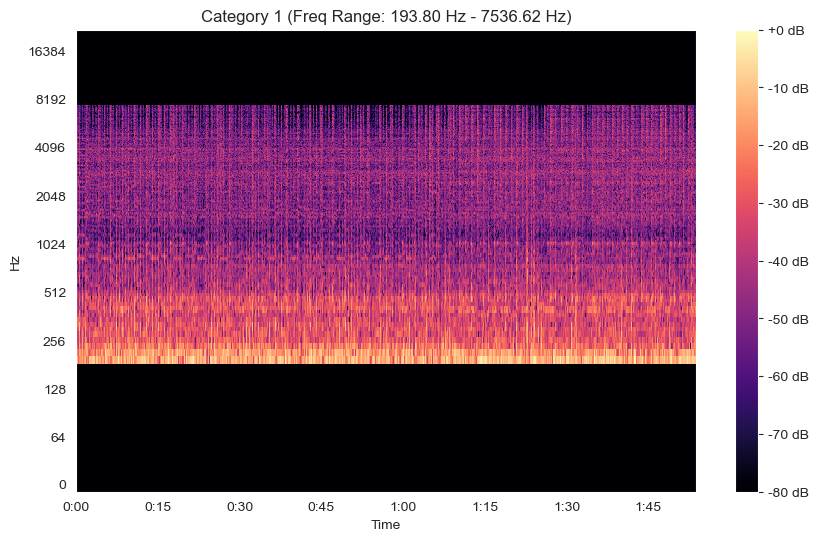

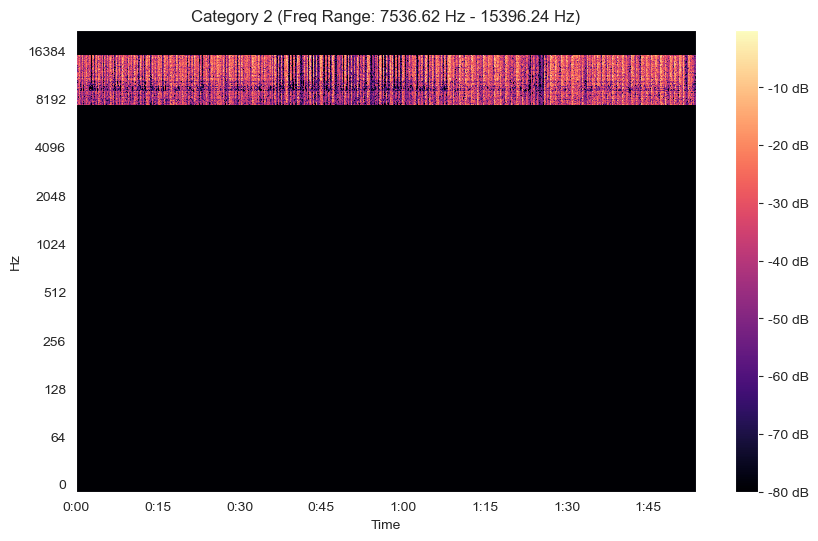

Reconstructed audio saved as 'reconstructed_audio.wav'


In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import soundfile as sf  # Use soundfile to save audio files

# Step 1: Load Audio and Convert to Frequency Domain (STFT)
def load_audio_and_stft(wav_file, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_file, sr=None)
    S_full = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D = librosa.amplitude_to_db(np.abs(S_full), ref=np.max)
    return y, sr, S_full, D

# Step 2: Categorize by Frequency Peaks (Ensure indices are within bounds)
def categorize_by_frequency(S_full, sr, n_categories=3):
    # Get frequency bins and magnitudes
    freqs = librosa.fft_frequencies(sr=sr, n_fft=S_full.shape[0] * 2 - 2)  # Corrected for frequency bins
    
    # Sum the magnitudes across time to get a frequency-wise profile
    freq_magnitudes = np.sum(np.abs(S_full), axis=1)
    
    # Find peaks in the frequency domain
    peaks, _ = find_peaks(freq_magnitudes, distance=len(freq_magnitudes) // n_categories)
    
    # Ensure the peaks are within bounds
    peaks = np.clip(peaks, 0, len(freq_magnitudes) - 1)
    
    # Split into frequency categories based on the peaks
    categories = []
    category_ranges = []
    
    # Ensure we are not going out of bounds
    for i in range(len(peaks) - 1):
        start_freq = peaks[i]
        end_freq = peaks[i + 1]
        category_ranges.append((freqs[start_freq], freqs[end_freq]))
        
        # Create a mask for this frequency range
        category_mask = np.zeros_like(S_full, dtype=bool)
        category_mask[start_freq:end_freq, :] = True
        
        # Apply the mask to the STFT
        categories.append(S_full * category_mask)
    
    return categories, category_ranges

# Step 3: Recombine the Components Based on Similarity in Time-Frequency Domain
def recombine_by_similarity(categories, sr, hop_length):
    # Recombine categories (placeholder logic)
    recombined = np.sum(categories, axis=0)
    
    # Inverse STFT to reconstruct the audio signal
    y_reconstructed = librosa.istft(recombined, hop_length=hop_length)
    return y_reconstructed

# Step 4: Visualization of the categories in Frequency Domain
def plot_spectrogram(D, sr, title):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Example Usage
wav_file = 'audio.wav'  # Replace with your audio file
y, sr, S_full, D = load_audio_and_stft(wav_file)

# Visualize the original audio in the frequency domain
plot_spectrogram(D, sr, 'Original Audio Spectrogram')

# Step 2: Separate by peaks in the frequency domain
categories, category_ranges = categorize_by_frequency(S_full, sr, n_categories=3)

# Visualize the separated categories in frequency domain
for i, (category, freq_range) in enumerate(zip(categories, category_ranges)):
    D_category = librosa.amplitude_to_db(np.abs(category), ref=np.max)
    plot_spectrogram(D_category, sr, f'Category {i+1} (Freq Range: {freq_range[0]:.2f} Hz - {freq_range[1]:.2f} Hz)')

# Step 3: Recombine the categories and reconstruct the audio
y_reconstructed = recombine_by_similarity(categories, sr, hop_length=512)

# Save the reconstructed audio using soundfile (replacing librosa.output.write_wav)
sf.write('reconstructed_audio.wav', y_reconstructed, sr)

print("Reconstructed audio saved as 'reconstructed_audio.wav'")


In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
import soundfile as sf  # Use soundfile to save audio files

# Step 1: Load Audio and Convert to Frequency Domain (STFT)
def load_audio_and_stft(wav_file, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_file, sr=None)
    S_full = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D = librosa.amplitude_to_db(np.abs(S_full), ref=np.max)
    return y, sr, S_full, D

# Step 2: Categorize by Frequency Peaks (Ensure indices are within bounds)
def categorize_by_frequency(S_full, sr, n_categories=3):
    # Get frequency bins and magnitudes
    freqs = librosa.fft_frequencies(sr=sr, n_fft=S_full.shape[0] * 2 - 2)  # Corrected for frequency bins
    
    # Sum the magnitudes across time to get a frequency-wise profile
    freq_magnitudes = np.sum(np.abs(S_full), axis=1)
    
    # Find peaks in the frequency domain
    peaks, _ = find_peaks(freq_magnitudes, distance=len(freq_magnitudes) // n_categories)
    
    # Ensure the peaks are within bounds
    peaks = np.clip(peaks, 0, len(freq_magnitudes) - 1)
    
    # Split into frequency categories based on the peaks
    categories = []
    category_ranges = []
    
    for i in range(len(peaks) - 1):
        start_freq = peaks[i]
        end_freq = peaks[i + 1]
        category_ranges.append((freqs[start_freq], freqs[end_freq]))
        
        # Create a mask for this frequency range
        category_mask = np.zeros_like(S_full, dtype=bool)
        category_mask[start_freq:end_freq, :] = True
        
        # Apply the mask to the STFT
        categories.append(S_full * category_mask)
    
    return categories, category_ranges

# Step 3: Recombine the Components Based on Similarity in Time-Frequency Domain
def recombine_by_similarity(categories, sr, hop_length):
    # Recombine categories (placeholder logic)
    recombined = np.sum(categories, axis=0)
    
    # Inverse STFT to reconstruct the audio signal
    y_reconstructed = librosa.istft(recombined, hop_length=hop_length)
    return y_reconstructed

# Step 4: Save the separated frequency categories as individual audio files
def save_categories_as_audio(categories, sr, hop_length, prefix='category'):
    for i, category in enumerate(categories):
        y_category = librosa.istft(category, hop_length=hop_length)
        output_file = f"{prefix}_{i+1}.wav"
        sf.write(output_file, y_category, sr)
        print(f"Saved category {i+1} as {output_file}")

# Step 5: Cluster the frequency categories into 2 clusters
def cluster_categories(categories, n_clusters=2):
    # Calculate the total energy of each category
    category_energy = [np.sum(np.abs(category)) for category in categories]
    category_energy = np.array(category_energy).reshape(-1, 1)  # Reshape for clustering

    # Use KMeans to cluster the categories based on their energy
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(category_energy)
    return labels

# Step 6: Perform ICA on each cluster
def perform_ica_on_clusters(categories, labels, n_components=2, sr=22050, hop_length=512):
    for cluster_label in np.unique(labels):
        print(f"Applying ICA to cluster {cluster_label + 1}")
        
        # Extract categories belonging to this cluster
        cluster_categories = [categories[i] for i in range(len(categories)) if labels[i] == cluster_label]
        combined_cluster = np.sum(cluster_categories, axis=0)  # Combine categories in this cluster
        
        # Perform ICA
        combined_cluster_transposed = combined_cluster.T
        ica = FastICA(n_components=n_components, random_state=42)
        S_ = ica.fit_transform(np.abs(combined_cluster_transposed))  # Reconstruct signals

        # Transpose back to (frequency, time)
        S_ = S_.T

        # Save the separated components for each cluster
        for i, component in enumerate(S_):
            y_component = librosa.istft(component, hop_length=hop_length)
            output_file = f"cluster_{cluster_label+1}_component_{i+1}.wav"
            sf.write(output_file, y_component, sr)
            print(f"Saved {output_file}")

# Example Usage
wav_file = 'audio.wav'  # Replace with your audio file
y, sr, S_full, D = load_audio_and_stft(wav_file)

# Visualize the original audio in the frequency domain
# plot_spectrogram(D, sr, 'Original Audio Spectrogram')

# Step 2: Separate by peaks in the frequency domain
categories, category_ranges = categorize_by_frequency(S_full, sr, n_categories=3)

# Save each separated category as audio
save_categories_as_audio(categories, sr, hop_length=512)

# Step 5: Cluster the categories into 2 clusters
labels = cluster_categories(categories, n_clusters=2)

# Step 6: Perform ICA on each cluster
perform_ica_on_clusters(categories, labels, n_components=2, sr=sr, hop_length=512)

# Recombine and save the full audio as well
y_reconstructed = recombine_by_similarity(categories, sr, hop_length=512)
sf.write('reconstructed_audio.wav', y_reconstructed, sr)
print("Reconstructed audio saved as 'reconstructed_audio.wav'")


Saved category 1 as category_1.wav
Saved category 2 as category_2.wav
Applying ICA to cluster 1


IndexError: tuple index out of range

In [5]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
import soundfile as sf  # Use soundfile to save audio files

# Step 1: Load Audio and Convert to Frequency Domain (STFT)
def load_audio_and_stft(wav_file, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_file, sr=None)
    S_full = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D = librosa.amplitude_to_db(np.abs(S_full), ref=np.max)
    return y, sr, S_full, D

# Step 2: Categorize by Frequency Peaks (Ensure indices are within bounds)
def categorize_by_frequency(S_full, sr, n_categories=3):
    # Get frequency bins and magnitudes
    freqs = librosa.fft_frequencies(sr=sr, n_fft=S_full.shape[0] * 2 - 2)  # Corrected for frequency bins
    
    # Sum the magnitudes across time to get a frequency-wise profile
    freq_magnitudes = np.sum(np.abs(S_full), axis=1)
    
    # Find peaks in the frequency domain
    peaks, _ = find_peaks(freq_magnitudes, distance=len(freq_magnitudes) // n_categories)
    
    # Ensure the peaks are within bounds
    peaks = np.clip(peaks, 0, len(freq_magnitudes) - 1)
    
    # Split into frequency categories based on the peaks
    categories = []
    category_ranges = []
    
    for i in range(len(peaks) - 1):
        start_freq = peaks[i]
        end_freq = peaks[i + 1]
        category_ranges.append((freqs[start_freq], freqs[end_freq]))
        
        # Create a mask for this frequency range
        category_mask = np.zeros_like(S_full, dtype=bool)
        category_mask[start_freq:end_freq, :] = True
        
        # Apply the mask to the STFT
        categories.append(S_full * category_mask)
    
    return categories, category_ranges

# Step 3: Recombine the Components Based on Similarity in Time-Frequency Domain
def recombine_by_similarity(categories, sr, hop_length):
    # Recombine categories (placeholder logic)
    recombined = np.sum(categories, axis=0)
    
    # Inverse STFT to reconstruct the audio signal
    y_reconstructed = librosa.istft(recombined, hop_length=hop_length)
    return y_reconstructed

# Step 4: Save the separated frequency categories as individual audio files
def save_categories_as_audio(categories, sr, hop_length, prefix='category'):
    for i, category in enumerate(categories):
        y_category = librosa.istft(category, hop_length=hop_length)
        output_file = f"{prefix}_{i+1}.wav"
        sf.write(output_file, y_category, sr)
        print(f"Saved category {i+1} as {output_file}")

# Step 5: Cluster the frequency categories into 2 clusters
def cluster_categories(categories, n_clusters=2):
    # Calculate the total energy of each category
    category_energy = [np.sum(np.abs(category)) for category in categories]
    category_energy = np.array(category_energy).reshape(-1, 1)  # Reshape for clustering

    # Use KMeans to cluster the categories based on their energy
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(category_energy)
    return labels

# Step 6: Perform ICA on each cluster
def perform_ica_on_clusters(categories, labels, n_components=2, sr=22050, hop_length=512):
    for cluster_label in np.unique(labels):
        print(f"Applying ICA to cluster {cluster_label + 1}")
        
        # Extract categories belonging to this cluster
        cluster_categories = [categories[i] for i in range(len(categories)) if labels[i] == cluster_label]
        combined_cluster = np.sum(cluster_categories, axis=0)  # Combine categories in this cluster
        
        # Perform ICA on the combined cluster
        combined_cluster_real = np.abs(combined_cluster).T  # Transpose and use absolute values for ICA
        ica = FastICA(n_components=n_components, random_state=42)
        S_ = ica.fit_transform(combined_cluster_real)  # Reconstruct signals

        # Transpose back to (frequency, time)
        S_ = S_.T

        # Save the separated components for each cluster
        for i, component in enumerate(S_):
            # Reshape component back to (frequency, time)
            component = component.reshape(combined_cluster.shape[1], -1)
            
            # Reconstruct the time-domain signal using ISTFT
            y_component = librosa.istft(component, hop_length=hop_length)
            output_file = f"cluster_{cluster_label+1}_component_{i+1}.wav"
            sf.write(output_file, y_component, sr)
            print(f"Saved {output_file}")

# Example Usage
wav_file = 'audio.wav'  # Replace with your audio file
y, sr, S_full, D = load_audio_and_stft(wav_file)

# Visualize the original audio in the frequency domain
# plot_spectrogram(D, sr, 'Original Audio Spectrogram')

# Step 2: Separate by peaks in the frequency domain
categories, category_ranges = categorize_by_frequency(S_full, sr, n_categories=3)

# Save each separated category as audio
save_categories_as_audio(categories, sr, hop_length=512)

# Step 5: Cluster the categories into 2 clusters
labels = cluster_categories(categories, n_clusters=2)

# Step 6: Perform ICA on each cluster
perform_ica_on_clusters(categories, labels, n_components=2, sr=sr, hop_length=512)

# Recombine and save the full audio as well
y_reconstructed = recombine_by_similarity(categories, sr, hop_length=512)
sf.write('reconstructed_audio.wav', y_reconstructed, sr)
print("Reconstructed audio saved as 'reconstructed_audio.wav'")


Saved category 1 as category_1.wav
Saved category 2 as category_2.wav
Applying ICA to cluster 1
Saved cluster_1_component_1.wav
Saved cluster_1_component_2.wav
Applying ICA to cluster 2
Saved cluster_2_component_1.wav
Saved cluster_2_component_2.wav
Reconstructed audio saved as 'reconstructed_audio.wav'
